<details>
<summary><b>Overview</b></summary>

## CIFAKE Dataset Analysis using CLIP Embeddings

This project analyzes the CIFAKE dataset (REAL vs FAKE images) using pretrained OpenAI CLIP embeddings.  
The goal is to compare real and generated images in embedding space, evaluate their similarity, and visualize the differences.

---

## Workflow Steps

### 1. Dataset Preparation
- Unzip the CIFAKE dataset into a working directory.
- Organize image paths for REAL and FAKE classes.
- Randomly sample 5000 images from each class for manageable computation.

### 2. CLIP Model Setup
- Load pretrained OpenAI CLIP model and processor using Hugging Face Transformers.
- The processor handles image preprocessing to match CLIP input requirements.

### 3. Image Embedding Extraction
- Use a batchwise approach to extract CLIP embeddings for sampled images.
- Concatenate batch embeddings and convert to NumPy arrays for further analysis.

### 4. Embedding Normalization
- Apply L2 normalization to embeddings for cosine similarity computations.

### 5. Similarity Computation
- Compute **centroid cosine similarity** between mean embeddings of REAL and FAKE.
- Compute **average pairwise cosine similarity** across all real vs fake embeddings.

### 6. FID Computation
- Compute per-class mean and covariance of embeddings.
- Use Fréchet distance to calculate FID between REAL and FAKE embeddings.
- Provides a quantitative measure of distributional similarity.

### 7. Dimensionality Reduction and Visualization
- Apply UMAP to project high-dimensional embeddings into 2D.
- Visualize REAL vs FAKE embeddings using a scatter plot.
- Allows visual assessment of overlap or separation between classes.

---
</details>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
from PIL import Image
from tqdm import tqdm
from scipy import linalg
import seaborn as sns

import tensorflow as tf

In [7]:
import zipfile

zip_path = "/content/cifake.zip"
extract_path = "/content/cifake"

# Create folder if doesnt exist
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [2]:
from transformers import CLIPProcessor, TFCLIPModel

model_name="openai/clip-vit-base-patch32"
model = TFCLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

config.json: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/606M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

def list_images(folder):
    return sorted([
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith(".jpg")
    ])

In [18]:
def get_clip_embeddings(images, batch_size=64):
    all_embeddings = []
    for i in tqdm(range(0, len(images), batch_size)):
        batch = images[i:i+batch_size]
        inputs = processor(images=batch, return_tensors="tf", padding=True)
        emb = model.get_image_features(**inputs)
        all_embeddings.append(emb)
    image_embeddings = tf.concat(all_embeddings, axis=0)
    return image_embeddings.numpy()


In [5]:
def l2_normalize_rows(x, eps=1e-12):
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return x / norms


In [6]:
def compute_statistics(embeddings):
    """
    embeddings: numpy array (N, D)
    returns (mu, sigma)
    """
    mu = np.mean(embeddings, axis=0)
    sigma = np.cov(embeddings, rowvar=False)
    return mu, sigma

def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Compute Fréchet distance between two multivariate Gaussians.
    """
    diff = mu1 - mu2
    # Add eps to diagonals to improve numerical stability
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if not np.isfinite(covmean).all():
        # Add small epsilon to diagonal and retry
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2.0 * tr_covmean
    return float(np.real(fid))

In [9]:
train_real = "/content/cifake/train/REAL"
train_fake = "/content/cifake/train/FAKE"

In [10]:
real_imgs = list_images(train_real)
fake_imgs = list_images(train_fake)

In [11]:
len(real_imgs)

50000

In [19]:
import random

sample_size = 5000
real_imgs_sample = random.sample(real_imgs, sample_size)
fake_imgs_sample = random.sample(fake_imgs, sample_size)

real_emb = get_clip_embeddings(real_imgs_sample)
fake_emb = get_clip_embeddings(fake_imgs_sample)


100%|██████████| 79/79 [01:39<00:00,  1.26s/it]


In [20]:
np.save("real_emb.npy", real_emb)
np.save("fake_emb.npy", fake_emb)

In [21]:
real_norm = l2_normalize_rows(real_emb)
fake_norm = l2_normalize_rows(fake_emb)

In [22]:
# Compute similarity
centroid_cos = np.dot(real_norm.mean(0), fake_norm.mean(0))
avg_cos = (real_norm @ fake_norm.T).mean()
print(f"Centroid Cosine: {centroid_cos:.4f}")
print(f"Avg Pairwise Cosine: {avg_cos:.4f}")

Centroid Cosine: 0.7869
Avg Pairwise Cosine: 0.7869


In [23]:
# Compute FID (reuse your existing frechet_distance)
mu_real, sigma_real = compute_statistics(real_emb)
mu_fake, sigma_fake = compute_statistics(fake_emb)

fid_score = frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID (REAL vs FAKE): {fid_score:.4f}")

FID (REAL vs FAKE): 5.4883


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


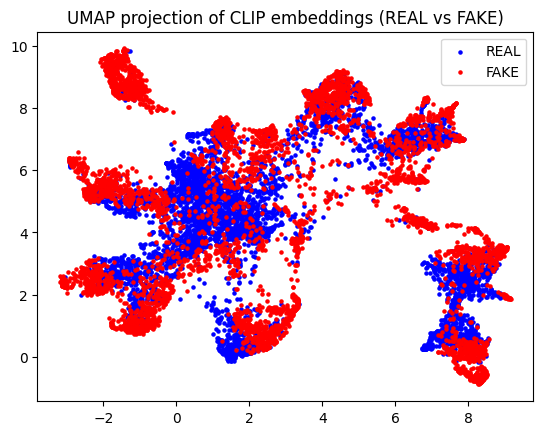

In [26]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
emb_2d = reducer.fit_transform(np.concatenate([real_norm, fake_norm]))

plt.scatter(emb_2d[:len(real_norm),0], emb_2d[:len(real_norm),1], s=5, c='blue', label='REAL')
plt.scatter(emb_2d[len(real_norm):,0], emb_2d[len(real_norm):,1], s=5, c='red', label='FAKE')
plt.legend()
plt.title("UMAP projection of CLIP embeddings (REAL vs FAKE)")
plt.show()
